In [149]:
import sys
import numpy as np
from datascience import *
import math 
# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [165]:
#this cell sets up measures of inflation by year, quarter, and month
cpiY = Table().read_table("CPI.csv").relabeled(1, "CPI")
cpiYs = cpiY.column("CPI")
piY = np.diff(cpiYs)/(cpiYs[:len(cpiYs) - 1])

cpiQ = Table().read_table("quarterlyCPI.csv").relabeled(1, "CPI")
cpiQs = cpiQ.column("CPI")
piQ = np.diff(cpiQs)/(cpiQs[:len(cpiQs) - 1])

cpiM = Table().read_table("monthlyCPI.csv").relabeled(1, "CPI")
cpiMs = cpiM.column("CPI")
piM = np.diff(cpiMs)/(cpiMs[:len(cpiMs) - 1])

inflation_by_year = Table().with_columns("DATE", np.arange(1947, 2016), "INFLATION RATE", piY)
inflation_by_quarter = Table().with_columns("DATE", cpiQ.column(0)[:len(piQ)], "INFLATION RATE", piQ)
inflation_by_month = Table().with_columns("DATE", cpiM.column(0)[:len(piM)], "INFLATION RATE", piM)
inflation_by_month = inflation_by_month.with_column("DATE", [x[:len(x) - 3] for x in inflation_by_month.column("DATE")]).where("INFLATION RATE", are.between(-.01, .02))

In [166]:
#this cell sets up the rest of the data
r = Table().read_table("r*.csv").select("TIME", "Value").relabeled("TIME", "DATE").relabeled("Value", "r")

unemployment = Table().read_table("unemployment.csv").relabeled(1, "UNEMPLOYMENT RATE")

y_pop = Table().read_table("Y*.csv").relabeled(1, "POTENTIAL GDP")

y = Table().read_table("Y.csv").relabeled(1, "GDP")

gdp = y.join("DATE", y_pop)

distress = Table().read_table("distress.csv").relabeled(1, "ECONOMIC CONDITION")
new_distress = []
for num in distress.column(1):
    if num < 60:
        new_distress.append("Emergency")
    elif num < 70:
        new_distress.append("Distressed")
    elif num < 80:
        new_distress.append("At-Risk")
    elif num < 60:
        new_distress.append("Good")
    else:
        new_distress.append("Excellent")
distress = distress.with_column("ECONOMIC CONDITION", new_distress)

## Quarterly Data from 1949 to Present

The table below contains real GDP, real potential GDP, unemployment rate, inflation rate, and level below potential per quarter.
GDP is defined as the market value of the final goods and services newly produced in a country during some period of time, adjusted for price changes. Potential GDP is this measure of output given by long-run economic variables such as capital, technology, amd employment at normal economic times (not in a recession/boom).

In [191]:
quarterly_data = gdp.join("DATE", unemployment).join("DATE", inflation_by_quarter)
quarterly_data = quarterly_data.with_column("OUTPUT MINUS POTENTIAL", quarterly_data.column(1) - quarterly_data.column(2)).with_column("DATE", [x[:len(x) - 3] for x in quarterly_data.column(0)])
quarterly_data

DATE,GDP,POTENTIAL GDP,UNEMPLOYMENT RATE,INFLATION RATE,OUTPUT MINUS POTENTIAL
1949-01,2007.5,2011.3,4.3,-0.00108591,-3.8
1949-04,2000.8,2038.1,5.3,-0.00836225,-37.3
1949-07,2022.8,2065.2,6.7,-0.00240334,-42.4
1949-10,2004.7,2092.6,7.9,-0.00308538,-87.9
1950-01,2084.6,2120.1,6.5,0.00763132,-35.5
1950-04,2147.6,2147.2,5.8,0.0183448,0.4
1950-07,2230.4,2174.7,5,0.0202454,55.7
1950-10,2273.4,2202.5,4.2,0.0406593,70.9
1951-01,2304.5,2230.8,3.7,0.00972876,73.7
1951-04,2344.5,2260.7,3.1,-0.000539561,83.8


** The economy is in a recession when real GDP (output adjusted for inflation) is below the economy's potential. We can see this effect below. **

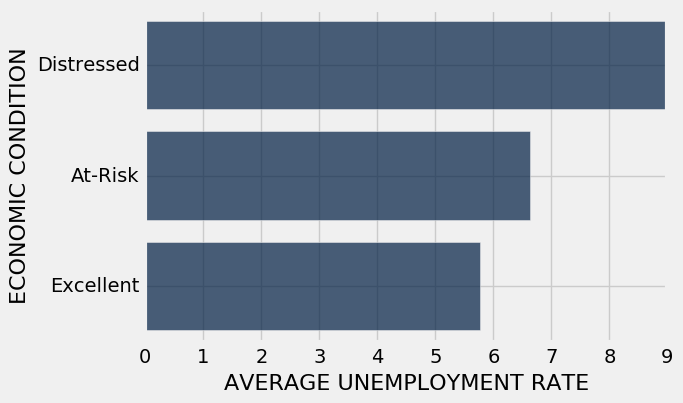

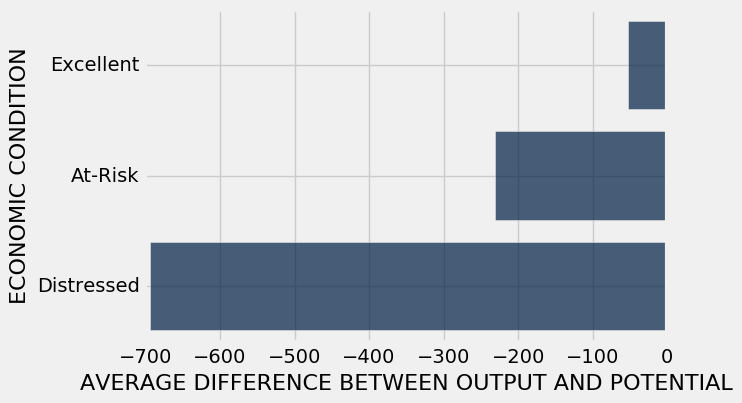

In [168]:
distress = distress.with_column("DATE", [x[:len(x) - 3] for x in distress.column("DATE")]).join("DATE", quarterly_data)
distress.group("ECONOMIC CONDITION", np.mean).relabeled("UNEMPLOYMENT RATE mean", "AVERAGE UNEMPLOYMENT RATE").sort("AVERAGE UNEMPLOYMENT RATE", descending = True).barh("ECONOMIC CONDITION", "AVERAGE UNEMPLOYMENT RATE")
distress.group("ECONOMIC CONDITION", np.mean).sort("OUTPUT MINUS POTENTIAL mean", descending = True).relabeled("OUTPUT MINUS POTENTIAL mean", "AVERAGE DIFFERENCE BETWEEN OUTPUT AND POTENTIAL").barh("ECONOMIC CONDITION", "AVERAGE DIFFERENCE BETWEEN OUTPUT AND POTENTIAL")

## The Great Recession

** Now we know that when output falls below potential, the economy is in worse shape (a condition reinforced by unemployment rate). We can see the U.S. economy's condition over time changing between 2000 and 2018 below.**

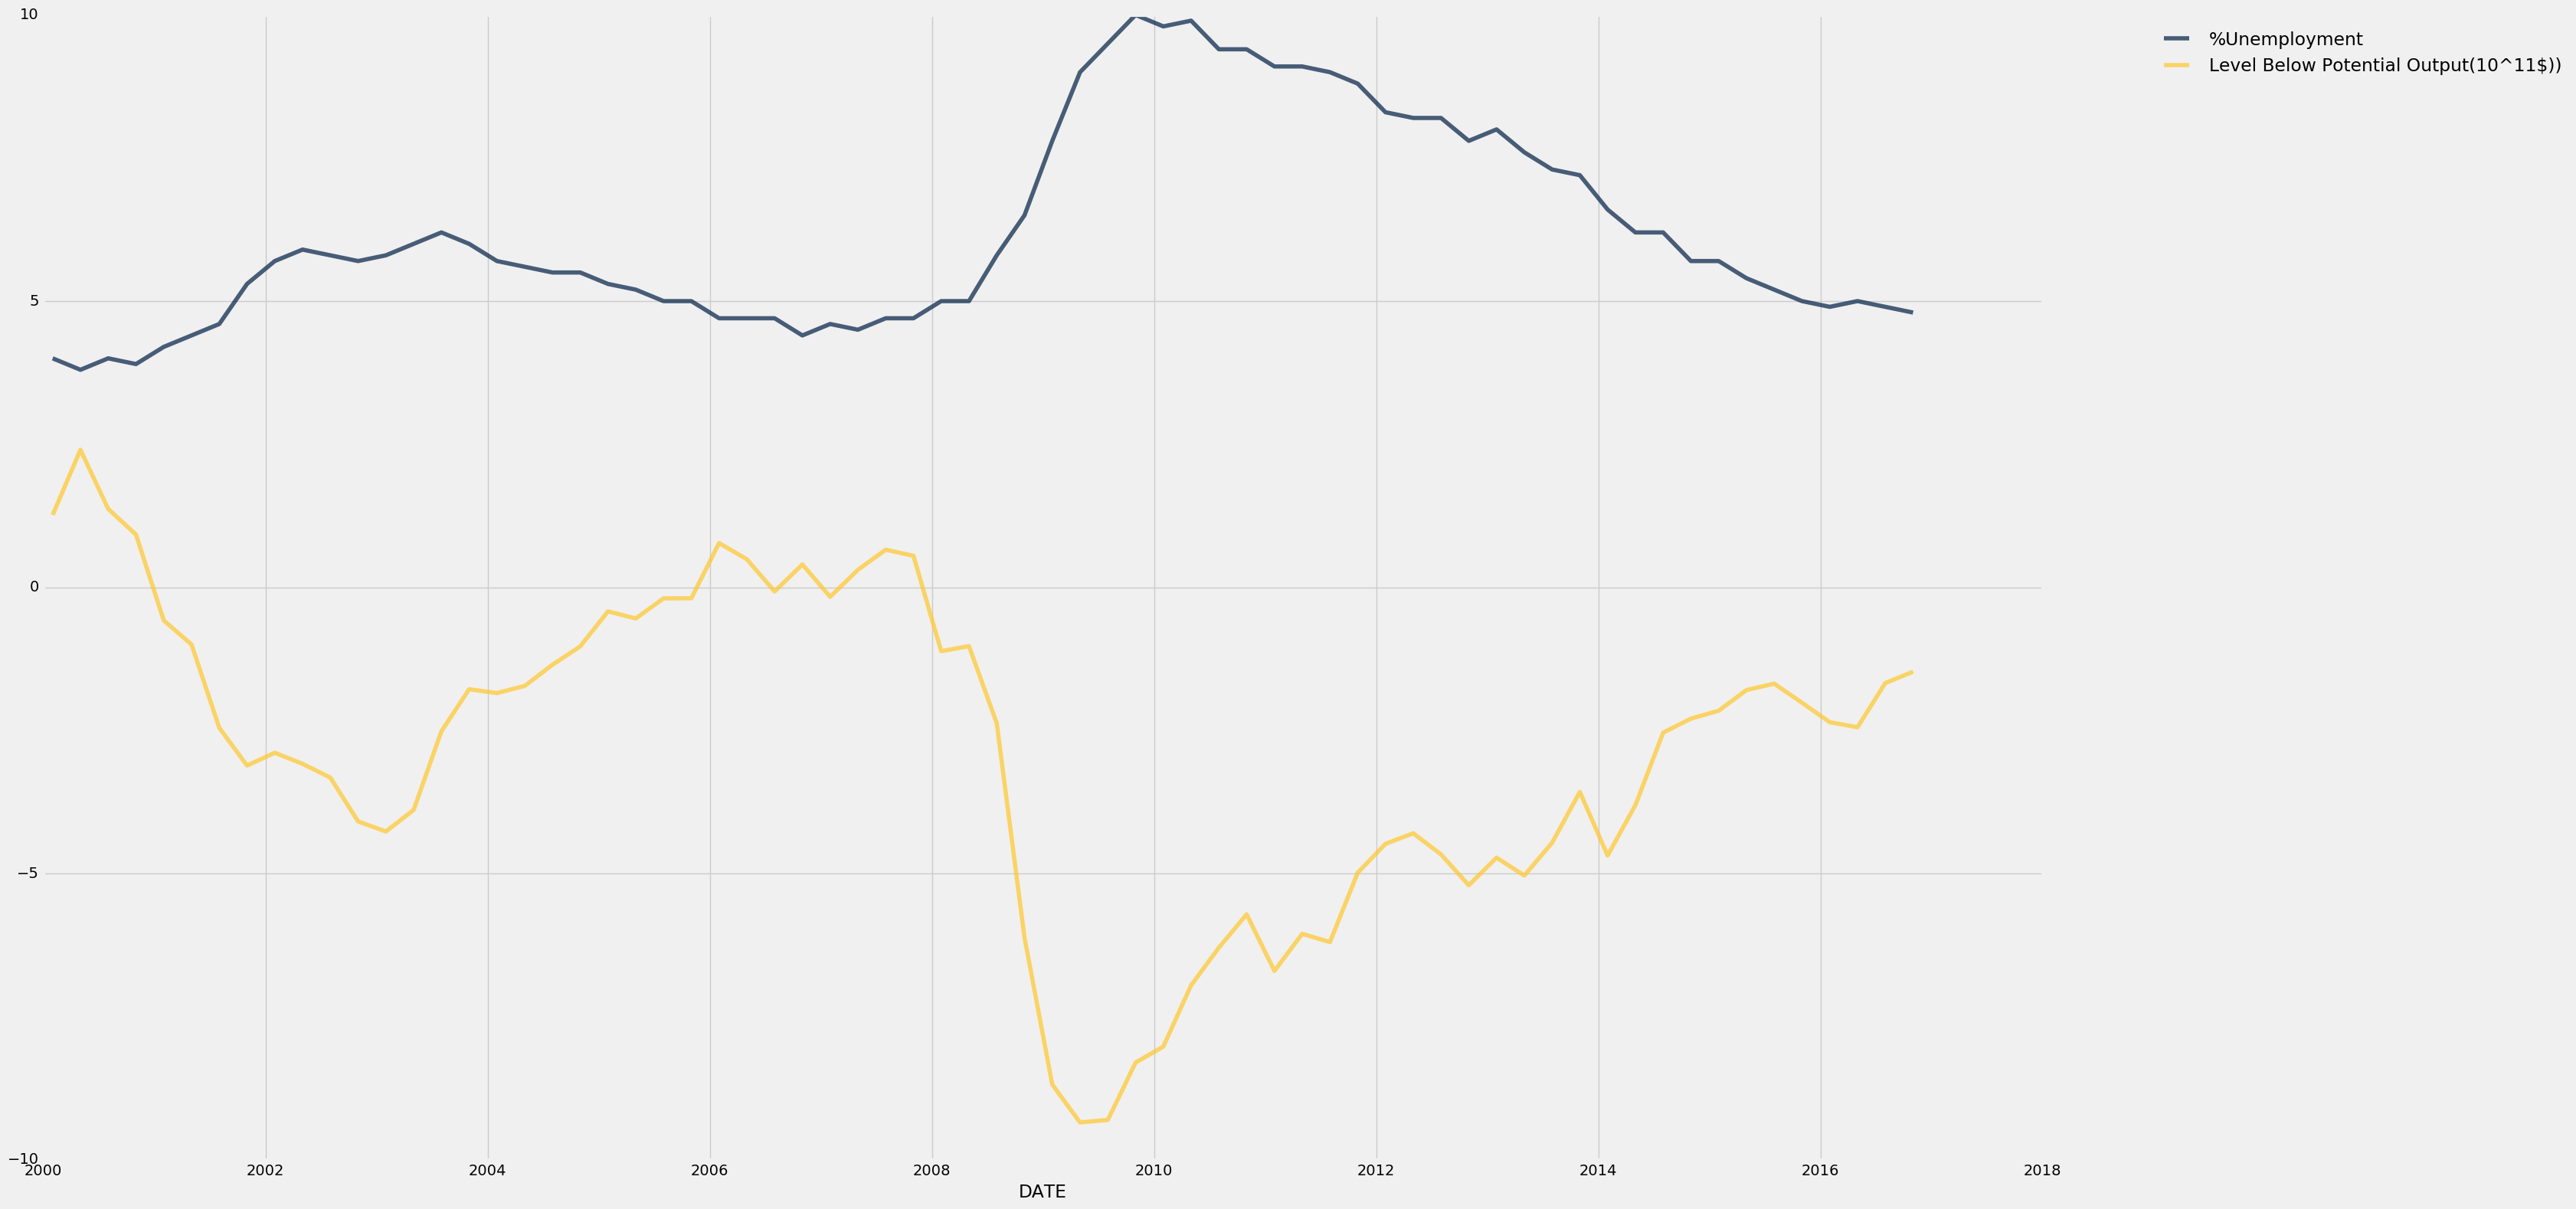

In [175]:
quarterly_w_time = quarterly_data.select("UNEMPLOYMENT RATE", "OUTPUT MINUS POTENTIAL").with_column("DATE", [int(x[:len(x) - 3]) + int(x[len(x) - 2:])/12 for x in quarterly_data.column("DATE")])
recession_line_data = quarterly_w_time.with_column("OUTPUT MINUS POTENTIAL", quarterly_w_time.column("OUTPUT MINUS POTENTIAL") / 100).relabeled("UNEMPLOYMENT RATE", "%Unemployment").relabeled("OUTPUT MINUS POTENTIAL", "Level Below Potential Output(10^11$))")
recession_line_data = recession_line_data.where("DATE", are.between(2000, 2018))
recession_line_data.plot("DATE", width = 30, height = 18)

There is a sharp decline in output and corresponding hike in unemployment around 2007. This is the Great Recession. In early 2008, the government took action to counteract the recession. ** Did monetary & fiscal policies have a real effect? ** We can use a hypothesis test to determine the likelihood that the recovery was really influenced by policy at all.

** Null Hypothesis: **

** Alternative Hypothesis: **

** Significance Level: **

** Test Statistic: **

In [182]:
yearly_data = quarterly_data.select("OUTPUT MINUS POTENTIAL").with_column("DATE", [int(x[:len(x) - 3]) for x in quarterly_data.column("DATE")]).relabeled("DATE", "YEAR")
yearly_data = yearly_data.group("YEAR", np.mean).relabeled("OUTPUT MINUS POTENTIAL mean", "GDP OUTPUT GAP")
num_changes = yearly_data.num_rows - 1
proportion_GDP_increases = np.count_nonzero(np.diff(yearly_data.column("GDP OUTPUT GAP")) > 0)/num_changes
proportion_GDP_increases

0.582089552238806

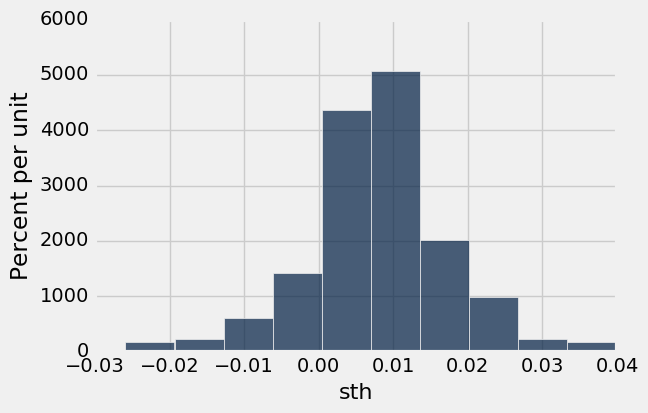

In [184]:
percentage_change_GDP = np.diff(y.column(1))/(y.column(1)[:y.num_rows - 1])
Table().with_column("sth", percentage_change_GDP).hist(0)

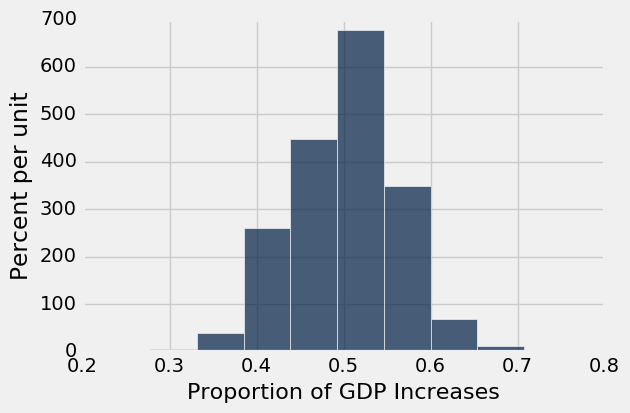

In [185]:
uniform_samples = make_array()
for i in np.arange(100000):
    sample = np.random.choice(2, num_changes)
    uniform_samples = np.append(uniform_samples, sum(sample)/num_changes)

Table().with_column('Proportion of GDP Increases', uniform_samples).hist(0)

In [186]:
p_val = 2 * np.count_nonzero(uniform_samples >= proportion_GDP_increases) / 100000
p_val

0.22084

In [187]:
# Now we can analyze the effect of fiscal & monetary policy on GDP
# Null Hypothesis : Govt. intervention has no effect -> GDP increase after 2008 is due to random chance
# Alternative Hypothesis: Govt. intervention increases GDP

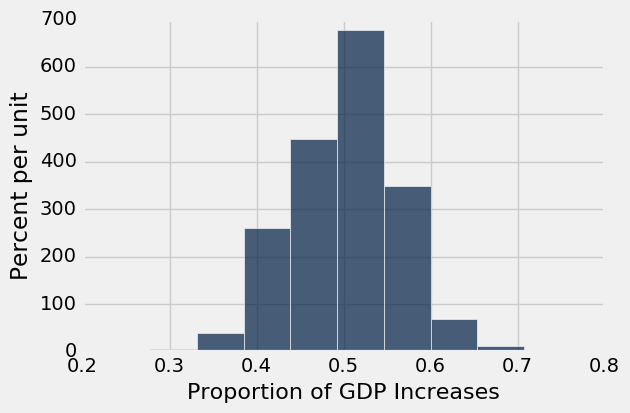

In [188]:
sample_increases = make_array()
for i in np.arange(100000):
    increase_or_decrease = np.random.choice(2)
    sample_increases = np.append(sample_increases, increase_or_decrease)

Table().with_column('Proportion of GDP Increases', uniform_samples).hist(0)

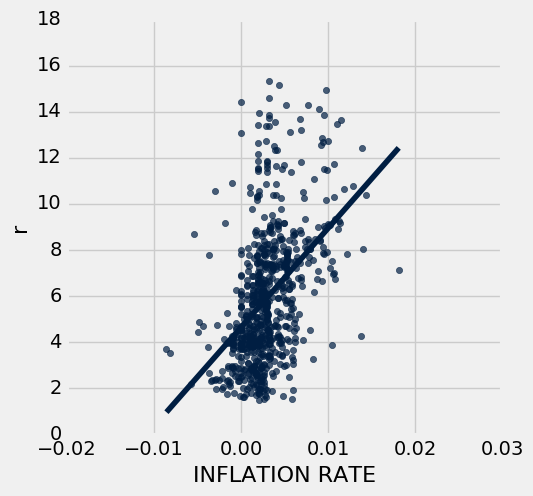

In [189]:
fed_reaction_function = inflation_by_month.join("DATE", r)
fed_reaction_function.scatter("INFLATION RATE", "r", fit_line = True)

In [90]:
#TO DO: PERFORM SOME REGRESSON TO FIND THE FEDS REACTION FUNCTION